* 아래 함수는 `weather_localcenter_metadata`와 `weather_5minute_ASOS_2020-2023.parquet`, `holiday.csv`를 사용하여 5분 단위 기상대표값을 도출합니다.
* 본 모델링에서는 기상인자로 최고기온, 최저기온, 평균일사량 데이터를 사용하고자 합니다. 일사량의 결측치 비율을 최소화 하기 위해 울산시를 제외한 특별시 및 광역시 데이터를 사용하였으며 (울산시 일사량 데이터의 대부분이 결측치였음), 강원도의 기상 인자도 반영하기 위해 도내에서 가장 인구가 많은 도시인 원주를 포함하였습니다.
* 보간법을 적용하기 전의 기온과 일사량의 결측치 비율은 전체 대비 0.2%, 0.4% 수준이며, 선형보간법을 통해 결측치를 보완하고자 했습니다.
* 단순히 휴일여부가 아니라 어떤 휴일에 해당하는지를 더미변수로 추가해보았습니다. (휴일이 아닌 날, 신정, 설날, 삼일절, 선거일, 어린이날, 석가탄신일, 현충일, 광복절, 추석, 개천절, 기독탄신일, 한글날, 대체공휴일 등 총 14가지로 분류)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/MyDrive/DL_Proj/'

/content/drive/MyDrive/DL_Proj


In [1]:
def weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path):

  import pandas as pd

  # 기상관측 MetaData 불러오기
  weather_metadata = pd.read_csv(weather_metadata_path)
  STN_dict = {STN_name : STN_num for STN_num, STN_name in zip(weather_metadata['지점'], weather_metadata['지점명'])}
  target_STN_list = [STN_dict[STN_name] for STN_name in ['서울', '부산', '인천', '대구', '대전', '광주', '원주']]

  # 서울 포함 7개 도시의 기온 및 일사량 데이터 불러오기
  weather_5minute = pd.read_parquet(weather_5minute_ASOS_path).astype({'지점' : 'int'})
  weather_5minute = weather_5minute[weather_5minute['지점'].isin(target_STN_list)]
  weather_5minute = weather_5minute[['지점', '일시', '기온(°C)', '일사(MJ/m^2)']]
  weather_5minute.columns = ['지점', '일시', '기온', '일사']

  column_list = ['기온', '일사']

  # 선형보간법 사용하여 결측값 채우기
  for idx, STN in enumerate(target_STN_list):

      # ① 각 STN별로 데이터 나누기
      tmp = weather_5minute[weather_5minute['지점'] == STN]

      # ② 시간순으로 정렬하기
      tmp = tmp.sort_values(by='일시')

      # ③ 선형보간법을 사용하여 nan값 채우기                
      for column in column_list:
        tmp[column] = tmp[column].interpolate(method='linear')

      # ④ tmp 합치기
      if idx == 0:
        interpolated_weather = tmp
      else:
        interpolated_weather = pd.concat([interpolated_weather, tmp])

  # 전국 기상 대표값 정하기 (최고기온, 최저기온, 평균일사량)
  for idx, column in enumerate(column_list):
    if column == '기온':
      # 최고 기온
      tmp_1 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].max()).rename(columns = {'기온' : 'max_temp'})
      # 최저 기온
      tmp_2 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].min()).rename(columns = {'기온' : 'min_temp'})
      tmp = pd.merge(tmp_1, tmp_2, on = '일시', how = 'inner')
    else:
      # 평균 일사량
      tmp = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].mean()).rename(columns = {'일사' : 'mean_insolation'})
    # ② groupby 결과를 인덱스 기준으로 Join
    if idx == 0:
      representative_weather = tmp
    else:
      representative_weather = pd.merge(representative_weather, tmp, on = '일시', how = 'inner')

  representative_weather.rename(columns = {'일시' : 'datetime'}, inplace= True)

  # 요일 특성 반영 (더미변수로 반영)
  # 0 : 월요일, 1 : 화요일 ~ 금요일, 2 : 토요일, 3 : 일요일

  representative_weather['weekday'] = pd.to_datetime(representative_weather['datetime']).dt.weekday
  representative_weather.replace({'weekday' : {2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 3}}, inplace = True)
  representative_weather = pd.get_dummies(representative_weather, columns = ['weekday'])
                                          
  # 휴일 유형에 맞춘 더미변수 반영

  holiday = pd.read_csv(holiday_path)

  for dateName in ['국회의원선거일', '대통령선거일', '동시지방선거일', '전국동시지방선거', '제21대 국회의원선거']:
    holiday.replace({'dateName' : {dateName : '선거일'}}, inplace = True)
  holiday.replace({'dateName' : {'1월1일' : '신정'}}, inplace = True)
  holiday.replace({'dateName' : {'부처님오신날' : '석가탄신일'}}, inplace = True)
  holiday.replace({'dateName' : {'어린이 날' : '어린이날'}}, inplace = True)
  holiday.replace({'dateName' : {'대체휴무일' : '대체공휴일'}}, inplace = True)
  holiday.replace({'dateName' : {'임시공휴일' : '대체공휴일'}}, inplace = True)

  nameToNumber = {dateName : idx + 1  for idx, dateName in enumerate(list(holiday['dateName'].unique()))}
  holiday.replace({'dateName' : nameToNumber}, inplace = True)
  holiday_dict = {locdate : dateName for dateName, locdate in zip(holiday['dateName'], holiday['locdate'])}

  for row_number in range(representative_weather.shape[0]):
    if representative_weather.at[row_number, 'datetime'][:-6] in list(holiday['locdate']):
      representative_weather.at[row_number, 'holiday'] = holiday_dict[representative_weather.at[row_number, 'datetime'][:-6]]
    else:
      representative_weather.at[row_number, 'holiday'] = 0

  representative_weather = pd.get_dummies(representative_weather, columns = ['holiday'])

  # 월, 시간 정보 반영 (더미변수로 반영)

  representative_weather['month'] = pd.to_datetime(representative_weather['datetime']).dt.month
  representative_weather = pd.get_dummies(representative_weather, columns = ['month'])
  representative_weather['hour'] = pd.to_datetime(representative_weather['datetime']).dt.hour
  representative_weather = pd.get_dummies(representative_weather, columns = ['hour'])

  return representative_weather

In [2]:
# 기상대표값 데이터 생성하기

weather_metadata_path = './data/weather_localcenter_metadata.csv'
weather_5minute_ASOS_path = './data/weather_5minute_ASOS_2020-2023.parquet'
holiday_path = './data/holidays.csv'
representative_weather = weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path)

전력 데이터는 지호님이 완성해주신 `power_demand_interpolated`를 사용하였습니다.

In [3]:
# 전력 데이터 불러오기

import pandas as pd

power = pd.read_csv('./data/power_demand_interpolated.csv')
power.columns = ['datetime', 'load']

기상인자 대표값과 보간 처리된 전력데이터를 일시를 기준으로 Inner Join합니다.

In [4]:
# 전력 데이터와 기상인자 데이터 합치기

target_df = pd.merge(representative_weather, power, on = 'datetime', how = 'inner')

Custom Dataset과 Dataloader를 사용하여 메모리 사용량을 줄였습니다.

In [105]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

class CustomDataset_origin(torch.utils.data.Dataset):
  def __init__(self, target_df, seq_len, step_len, stride, mode='train'):

    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
    self.train_index = target_df[target_df['datetime'] < '2023-03-06'].index[-1] - step_len + 1
    self.val_index = (target_df[(target_df['datetime'] < '2023-03-13') & (target_df['datetime'] >= '2023-03-06')].index[0] - seq_len, 
                      target_df[(target_df['datetime'] < '2023-03-13') & (target_df['datetime'] >= '2023-03-06')].index[-1] + step_len + 1)
    self.test_index = (target_df[(target_df['datetime'] < '2023-03-20') & (target_df['datetime'] >= '2023-03-13')].index[0] - seq_len, 
                       target_df[(target_df['datetime'] < '2023-03-20') & (target_df['datetime'] >= '2023-03-13')].index[-1] + step_len + 1)
    
    self.X_train = target_df.iloc[:self.train_index,1:]
    self.y_train = target_df.iloc[:self.train_index,-1]
    self.X_val = target_df.iloc[self.val_index[0]:self.val_index[1],1:]
    self.y_val = target_df.iloc[self.val_index[0]:self.val_index[1],-1]
    self.X_test = target_df.iloc[self.test_index[0]:self.test_index[1],1:]
    self.y_test = target_df.iloc[self.test_index[0]:self.test_index[1],-1]

    self.x_scaler = MinMaxScaler()
    self.y_scaler = MinMaxScaler()

    self.mode = mode

    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride

  def fit_scale_x(self):
    self.X_train = self.x_scaler.fit_transform(self.X_train)
    self.X_val = self.x_scaler.transform(self.X_val)  
    self.X_test = self.x_scaler.transform(self.X_test)

  def fit_scale_y(self):
    self.y_train = self.y_scaler.fit_transform(np.array(self.y_train).reshape(-1,1))
    self.y_val = self.y_scaler.transform(np.array(self.y_val).reshape(-1,1))
    self.y_test = self.y_scaler.transform(np.array(self.y_test).reshape(-1,1))

  def numpy_to_torch(self):
    self.X_train = torch.FloatTensor(self.X_train).cuda()
    self.y_train = torch.FloatTensor(self.y_train).cuda()
    self.X_val = torch.FloatTensor(self.X_val).cuda()
    self.y_val = torch.FloatTensor(self.y_val).cuda()
    self.X_test = torch.FloatTensor(self.X_test).cuda()
    self.y_test = torch.FloatTensor(self.y_test).cuda()

  def set_mode(self, mode):
    self.mode = mode

  def __len__(self):
    if self.mode == 'train':
        return (self.X_train.shape[0] - step_len - seq_len) // stride
    elif self.mode == 'val':
        return (self.X_val.shape[0] - step_len - seq_len) // stride
    elif self.mode == 'test':
        return (self.X_test.shape[0] - step_len - seq_len) // stride
    else:
        print("mode를 다시 확인하세요")
  
  def __getitem__(self, idx):
    if self.mode == 'train':
        return self.X_train[idx*self.stride :idx*self.stride + self.seq_len], self.y_train[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len]
    elif self.mode == 'val':
        return self.X_val[idx*self.stride :idx*self.stride + self.seq_len], self.y_val[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len]
    elif self.mode == 'test':
        return self.X_test[idx*self.stride :idx*self.stride + self.seq_len], self.y_test[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len]
    else:
        print("mode를 다시 확인하세요")

In [5]:
## 전력수요만으로 전력수요 예측하기 테스트 코드

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, target_df, seq_len, step_len, stride, mode='train'):

    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride

    self.train_index = target_df[target_df['datetime'] < '2023-03-06'].index[-1] - step_len + 1
    self.val_index = (target_df[(target_df['datetime'] < '2023-03-13') & (target_df['datetime'] >= '2023-03-06')].index[0] - seq_len, 
                      target_df[(target_df['datetime'] < '2023-03-13') & (target_df['datetime'] >= '2023-03-06')].index[-1] + step_len + 1)
    self.test_index = (target_df[(target_df['datetime'] < '2023-03-20') & (target_df['datetime'] >= '2023-03-13')].index[0] - seq_len, 
                       target_df[(target_df['datetime'] < '2023-03-20') & (target_df['datetime'] >= '2023-03-13')].index[-1] + step_len + 1)
    
    self.X_train = target_df.iloc[:self.train_index,-1]
    self.y_train = target_df.iloc[:self.train_index,-1]
    self.X_val = target_df.iloc[self.val_index[0]:self.val_index[1],-1]
    self.y_val = target_df.iloc[self.val_index[0]:self.val_index[1],-1]
    self.X_test = target_df.iloc[self.test_index[0]:self.test_index[1],-1]
    self.y_test = target_df.iloc[self.test_index[0]:self.test_index[1],-1]

    self.x_scaler = MinMaxScaler()
    self.y_scaler = MinMaxScaler()

    self.mode = mode

    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride

  def fit_scale_x(self):
    self.X_train = self.x_scaler.fit_transform(np.array(self.X_train).reshape(-1,1))
    self.X_val = self.x_scaler.transform(np.array(self.X_val).reshape(-1,1))  
    self.X_test = self.x_scaler.transform(np.array(self.X_test).reshape(-1,1))

  def fit_scale_y(self):
    self.y_train = self.y_scaler.fit_transform(np.array(self.y_train).reshape(-1,1))
    self.y_val = self.y_scaler.transform(np.array(self.y_val).reshape(-1,1))
    self.y_test = self.y_scaler.transform(np.array(self.y_test).reshape(-1,1))

  def numpy_to_torch(self):
    self.X_train = torch.FloatTensor(self.X_train).cuda()
    self.y_train = torch.FloatTensor(self.y_train).cuda()
    self.X_val = torch.FloatTensor(self.X_val).cuda()
    self.y_val = torch.FloatTensor(self.y_val).cuda()
    self.X_test = torch.FloatTensor(self.X_test).cuda()
    self.y_test = torch.FloatTensor(self.y_test).cuda()

  def set_mode(self, mode):
    self.mode = mode

  def __len__(self):
    if self.mode == 'train':
        return (self.X_train.shape[0] - step_len - seq_len) // stride
    elif self.mode == 'val':
        return (self.X_val.shape[0] - step_len - seq_len) // stride
    elif self.mode == 'test':
        return (self.X_test.shape[0] - step_len - seq_len) // stride
    else:
        print("mode를 다시 확인하세요")
  
  def __getitem__(self, idx):
    if self.mode == 'train':
        return self.X_train[idx*self.stride :idx*self.stride + self.seq_len], self.y_train[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len]
    elif self.mode == 'val':
        return self.X_val[idx*self.stride :idx*self.stride + self.seq_len], self.y_val[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len]
    elif self.mode == 'test':
        return self.X_test[idx*self.stride :idx*self.stride + self.seq_len], self.y_test[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len]
    else:
        print("mode를 다시 확인하세요")

In [57]:
# CustomDataset 파라미터 설정 (Scaler 객체, 시퀀스의 길이, 스텝 사이즈, 건너뛸 간격)
seq_len = 2016 # 시퀀스의 길이
step_len = 72 # 스텝 사이즈 (추정하고자 하는 값의 개수)
stride = 1 # 건너뛸 간격

# 데이터셋 생성
dataset = CustomDataset(target_df, seq_len, step_len, stride)
dataset.fit_scale_x()
dataset.fit_scale_y()
dataset.numpy_to_torch()

# 모드 셋팅
dataset.set_mode('train')

# 데이터 로더 생성
dataloader = DataLoader(dataset, batch_size = 256, shuffle = True)

In [ ]:
dataset.set_mode('train')
next(iter(dataloader))[0].shape

torch.Size([256, 2016, 1])

In [ ]:
## 태진님코드

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor = torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.fit_transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1],
                                                               pd.DataFrame(scaler_for_Y.fit_transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = (self.dataset_tensor.shape[0] - step_len - seq_len) // stride
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride

  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# Scaler 객체 생성
ss_1 = MinMaxScaler() # Scaler for X
ss_2 = MinMaxScaler() # Scaler for y

# CustomDataset 파라미터 설정 (Scaler 객체, 시퀀스의 길이, 스텝 사이즈, 건너뛸 간격)
seq_len = 2016 # 시퀀스의 길이
step_len = 72 # 스텝 사이즈 (추정하고자 하는 값의 개수)
stride = 1 # 건너뛸 간격

# 데이터셋 생성
dataset2 = CustomDataset(target_df, 4, ss_1, ss_2, seq_len, step_len, stride)

# 학습용, 테스트용 데이터셋 분리
train_size2 = int(round(len(dataset2) * 0.8))
train_dataset2 = Subset(dataset2, [i for i in range(train_size2)])
test_dataset2 = Subset(dataset2, [i for i in range(train_size2, len(dataset))])

# 데이터 로더 생성
train_dataloader2 = DataLoader(train_dataset2, batch_size = 256, shuffle = True, drop_last = True)
val_dataloader2 = DataLoader(test_dataset2, batch_size = 32, shuffle = True, drop_last = True)

In [9]:
import torch.nn as nn

# 모델 구성하기

input_dim = 1 # 입력 컬럼의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 30 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
    )
  
  def forward(self, x):
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [ ]:
!pip install torchmetrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchmetrics import MeanAbsolutePercentageError

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 모델 학습 함수 만들기

def train_model(model, train_dataloader, val_dataloader=None, num_epochs = None, lr = None, verbose = 10, patience = 10):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  nb_epochs = num_epochs
  mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

  # epoch마다 loss 저장
  train_hist = np.zeros(nb_epochs)
  output = []
  
  for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_dataloader)
    for batch_idx, samples in enumerate(train_dataloader):
      x_train, y_train = samples
      # seq별 hidden state reset
      model.reset_hidden_state()
      # H(x) 계산
      outputs = model(x_train)
      # cost 계산
      loss = mean_abs_percentage_error(outputs, np.squeeze(y_train))
      # cost로 H(x) 개선
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_cost += loss/total_batch 

    train_hist[epoch] = avg_cost

    if epoch % verbose == 0:
      print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
    # patience번째 마다 early stopping 여부 확인
    # if (epoch % patience == 0) & (epoch != 0):
    #   if train_hist[epoch-patience] < train_hist[epoch]:
        # print('\n Early Stopping')
    #     break
  
  return model.eval(), train_hist

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# 모델 학습 (LSTM layer를 2개로 설정하였습니다.)

input_dim = 1 # 입력 컬럼의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.001 # 학습률
nb_epochs = 50 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)


net = Net(input_dim, hidden_dim, seq_length, output_dim, 2).to(device)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs,
                                lr = learning_rate, verbose = 1, patience = 4)

Epoch: 0000 train loss : 0.8040
Epoch: 0001 train loss : 1.5127
Epoch: 0002 train loss : 1.0982
Epoch: 0003 train loss : 1.0548
Epoch: 0004 train loss : 1.0521
Epoch: 0005 train loss : 1.0451
Epoch: 0006 train loss : 1.1109
Epoch: 0007 train loss : 1.1915
Epoch: 0008 train loss : 1.2061
Epoch: 0009 train loss : 1.0589
Epoch: 0010 train loss : 0.8470
Epoch: 0011 train loss : 0.5066
Epoch: 0012 train loss : 0.4770
Epoch: 0013 train loss : 0.4544
Epoch: 0014 train loss : 0.4631
Epoch: 0015 train loss : 0.3766
Epoch: 0016 train loss : 0.3612
Epoch: 0017 train loss : 0.3183
Epoch: 0018 train loss : 0.3143
Epoch: 0019 train loss : 0.3015
Epoch: 0020 train loss : 0.2751
Epoch: 0021 train loss : 0.2546
Epoch: 0022 train loss : 0.2614
Epoch: 0023 train loss : 0.2826
Epoch: 0024 train loss : 0.2810
Epoch: 0025 train loss : 0.2671
Epoch: 0026 train loss : 0.2466
Epoch: 0027 train loss : 0.2895
Epoch: 0028 train loss : 0.2786
Epoch: 0029 train loss : 0.2719
Epoch: 0030 train loss : 0.2538
Epoch: 0

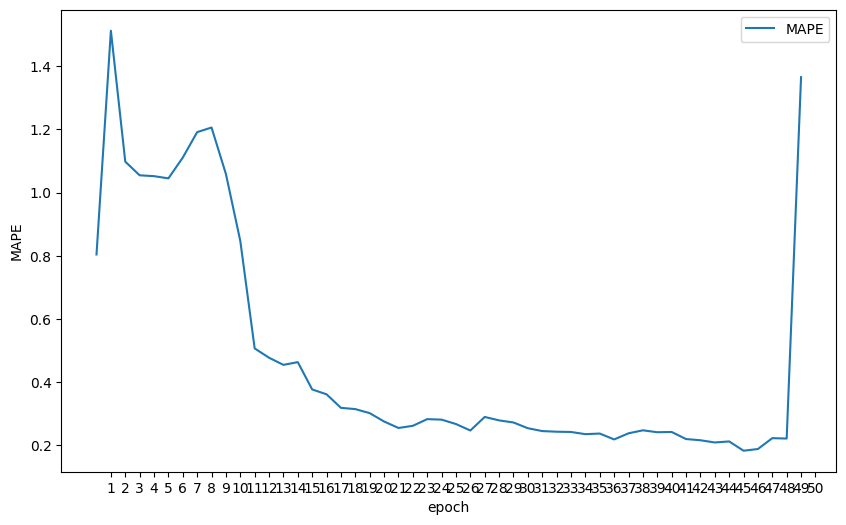

In [ ]:
# 학습 중 MAPE 추이 확인

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,6))
plt.plot(train_hist, label = 'MAPE')
plt.xlabel('epoch')
plt.xticks([i for i in range(1, 51)])
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [ ]:
torch.save(model,'model_20230525_2.pth')

In [ ]:
dataloader

In [ ]:
# 모델 검증

dataset.set_mode('test')

def MAPE(true, pred):
    return np.mean(np.abs((true-pred)/true))

with torch.no_grad():
  MAPE_list = []
  pred_list = []
  true_list = []
  for X, y in dataloader:
    # 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    # Scaler로 원래 값으로 돌려놓기
    pred_inverse = dataset.y_scaler.inverse_transform(np.array(pred.cpu()))
    testY_inverse = dataset.y_scaler.inverse_transform(np.squeeze(y).to('cpu'))
    pred_list.append(pred_inverse)
    true_list.append(testY_inverse)
    # Calculate MAPE
    MAPE_list.append(round(MAPE(testY_inverse, pred_inverse)*100, 3))

In [ ]:
print('평균 MAPE는 {}% 입니다'.format(round(sum(MAPE_list) / len(MAPE_list), 3)))

평균 MAPE는 5.8% 입니다


In [ ]:
true_list.__len__()

7

In [ ]:
# 무작위하게 고른 샘플의 백분율 오차 확인

np.abs(pred_list[5][0] - true_list[5][0])/ true_list[5][0]

array([4.53031244e-03, 3.58087802e-03, 9.30015796e-03, 9.10968216e-03,
       1.47330227e-02, 8.23269317e-05, 2.40396663e-04, 8.17003558e-03,
       3.23523541e-02, 2.00079782e-03, 7.01463945e-03, 3.01222009e-03,
       1.58032735e-02, 6.84075255e-03, 6.60746471e-03, 4.33133399e-03,
       7.41417585e-03, 5.91901836e-03, 1.01892851e-02, 4.35942480e-03,
       9.81045452e-03, 2.17521737e-02, 4.64383117e-03, 1.59809504e-03,
       2.23350650e-02, 7.53309972e-03, 1.74476136e-02, 1.79403916e-03,
       1.81805644e-03, 1.28377133e-02, 3.72010065e-03, 1.07087143e-03,
       2.76981200e-03, 7.84684780e-03, 1.24839816e-02, 1.48326543e-02,
       2.16022930e-02, 4.52541716e-02, 2.89915398e-02, 4.55755080e-02,
       3.80549206e-02, 4.72780136e-02, 4.31451516e-02, 6.49739978e-02,
       5.33309868e-02, 6.34124133e-02, 4.05736594e-02, 5.95900596e-02,
       5.80481893e-02, 8.12127646e-02, 5.41937443e-02, 7.13761735e-02,
       7.24246830e-02, 5.77500960e-02, 6.35926572e-02, 4.69791622e-02,
      

In [135]:
import torch.nn as nn

# 양방향 LSTM 모델 구성하기

input_dim = 58 # 입력 컬럼의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 50 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

class BiNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_len, out_dim, layers):
    super(BiNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True, bidirectional = True)
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
    )
  
  def forward(self, x):
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [136]:
import torch.nn as nn

# CNN + 양방향 LSTM 모델 구성하기

in_channels = 58 # 입력 컬럼의 개수
out_channels = 116 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
kernel_size = 3 # 합성곱 필터의 kernel_size
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 30 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

class CNN_BILSTM(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):
    super(CNN_BILSTM, self).__init__()
    # 입력인자 정의
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    # 합성곱 Layer 정의
    self.conv1d = nn.Conv1d(in_channels = self.in_channels, 
                            out_channels = self.out_channels,
                            kernel_size = self.kernel_size, 
                            padding = 'same')
    # LSTM Layer 정의
    self.lstm = nn.LSTM(self.out_channels, 
                        self.hidden_dim, 
                        num_layers = self.layers, 
                        batch_first = True, 
                        bidirectional = True)
    # 완전연결층 정의
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
  
  # 결과값 계산
  def forward(self, x):
    x = torch.transpose(x, 1, 2)
    x = self.conv1d(x)
    x = torch.transpose(x, 1, 2)
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [10]:
model = Net(input_dim, hidden_dim, seq_length, output_dim, 2)

In [11]:
model = torch.load('model_20230525_2.pth')

In [137]:
input_dim = 58 # 입력 컬럼의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 50 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

model_binet = Net(input_dim, hidden_dim, seq_length, output_dim, 2)
model_binet = torch.load('model_20230526_BILSTM.pth')

In [138]:
in_channels = 58 # 입력 컬럼의 개수
out_channels = 116 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
kernel_size = 3 # 합성곱 필터의 kernel_size
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 30 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

model_cnnlstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers = 2)
model_cnnlstm = torch.load('model_20230526_CNN-BILSTM.pth')

In [139]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchmetrics import MeanAbsolutePercentageError

In [141]:
# CustomDataset 파라미터 설정 (Scaler 객체, 시퀀스의 길이, 스텝 사이즈, 건너뛸 간격)
seq_len = 2016 # 시퀀스의 길이
step_len = 72 # 스텝 사이즈 (추정하고자 하는 값의 개수)
stride = 1 # 건너뛸 간격

# 데이터셋 생성
dataset2 = CustomDataset(target_df, seq_len, step_len, stride)
dataset2.fit_scale_x()
dataset2.fit_scale_y()
dataset2.numpy_to_torch()

# 모드 셋팅
dataset2.set_mode('train')

# 데이터 로더 생성
dataloader2 = DataLoader(dataset2, batch_size = 288)

In [142]:
# CustomDataset 파라미터 설정 (Scaler 객체, 시퀀스의 길이, 스텝 사이즈, 건너뛸 간격)
seq_len = 2016 # 시퀀스의 길이
step_len = 72 # 스텝 사이즈 (추정하고자 하는 값의 개수)
stride = 1 # 건너뛸 간격

# 데이터셋 생성
dataset2 = CustomDataset_origin(target_df, seq_len, step_len, stride)
dataset2.fit_scale_x()
dataset2.fit_scale_y()
dataset2.numpy_to_torch()

# 모드 셋팅
dataset2.set_mode('train')

# 데이터 로더 생성
dataloader2 = DataLoader(dataset2, batch_size = 288)

In [144]:
dataset.set_mode('test')

def MAPE(true, pred):
    return np.mean(np.abs((true-pred)/true))

with torch.no_grad():
  MAPE_list = []
  pred_list = []
  true_list = []
  for X, y in dataloader2:
    # 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)
    pred = model_binet(X)
    # Scaler로 원래 값으로 돌려놓기
    pred_inverse = dataset.y_scaler.inverse_transform(np.array(pred.cpu()))
    testY_inverse = dataset.y_scaler.inverse_transform(np.squeeze(y).to('cpu'))
    pred_list.append(pred_inverse)
    true_list.append(testY_inverse)
    # Calculate MAPE
    MAPE_list.append(round(MAPE(testY_inverse, pred_inverse)*100, 3))

print('평균 MAPE는 {}% 입니다'.format(round(sum(MAPE_list) / len(MAPE_list), 3)))

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.53 GiB (GPU 0; 4.00 GiB total capacity; 1.77 GiB already allocated; 1.45 GiB free; 1.83 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [113]:
dataset2.set_mode('test')

def MAPE(true, pred):
    return np.mean(np.abs((true-pred)/true))

with torch.no_grad():
  MAPE_list_bi = []
  pred_list2_bi = []
  true_list2_bi = []
  for X, y in dataloader2:
    # 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)
    pred = model2(X)
    # Scaler로 원래 값으로 돌려놓기
    pred_inverse = dataset.y_scaler.inverse_transform(np.array(pred.cpu()))
    testY_inverse = dataset.y_scaler.inverse_transform(np.squeeze(y).to('cpu'))
    pred_list_bi.append(pred_inverse)
    true_list_bi.append(testY_inverse)
    # Calculate MAPE
    MAPE_list_bi.append(round(MAPE(testY_inverse, pred_inverse)*100, 3))

print('평균 MAPE는 {}% 입니다'.format(round(sum(MAPE_list) / len(MAPE_list), 3)))

평균 MAPE는 3.831% 입니다


In [ ]:
dataset2.set_mode('test')

def MAPE(true, pred):
    return np.mean(np.abs((true-pred)/true))

with torch.no_grad():
  MAPE_list_cnn = []
  pred_list2_cnn = []
  true_list2_cnn = []
  for X, y in dataloader2:
    # 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)
    pred = model_cnn(X)
    # Scaler로 원래 값으로 돌려놓기
    pred_inverse = dataset.y_scaler.inverse_transform(np.array(pred.cpu()))
    testY_inverse = dataset.y_scaler.inverse_transform(np.squeeze(y).to('cpu'))
    pred_list_bi.append(pred_inverse)
    true_list_bi.append(testY_inverse)
    # Calculate MAPE
    MAPE_list_bi.append(round(MAPE(testY_inverse, pred_inverse)*100, 3))

print('평균 MAPE는 {}% 입니다'.format(round(sum(MAPE_list) / len(MAPE_list), 3)))

In [80]:
import matplotlib.pyplot as plt

In [91]:
target_df.set_index('datetime').loc['2023-03-13':'2023-03-20', 'load']

datetime
2023-03-13 00:00    58782.0
2023-03-13 00:05    58954.4
2023-03-13 00:10    58710.6
2023-03-13 00:15    58298.4
2023-03-13 00:20    58263.7
                     ...   
2023-03-19 23:35    58627.2
2023-03-19 23:40    57941.2
2023-03-19 23:45    57726.2
2023-03-19 23:50    57755.4
2023-03-19 23:55    57323.8
Name: load, Length: 2016, dtype: float64

In [95]:
from datetime import datetime, timedelta

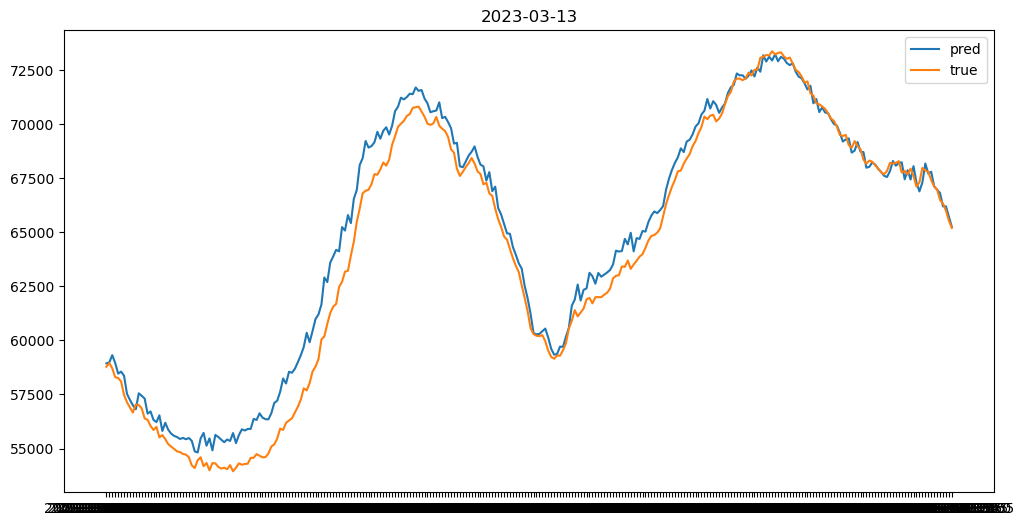

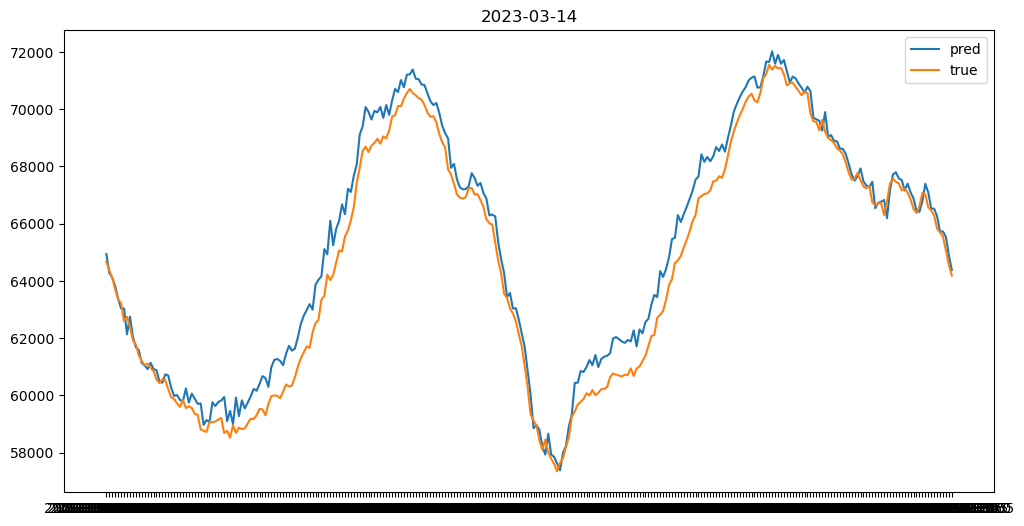

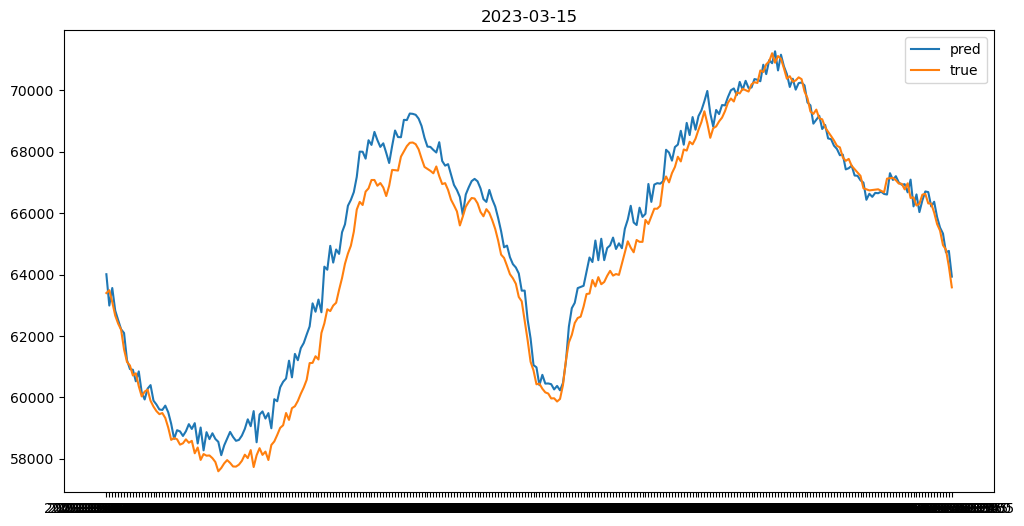

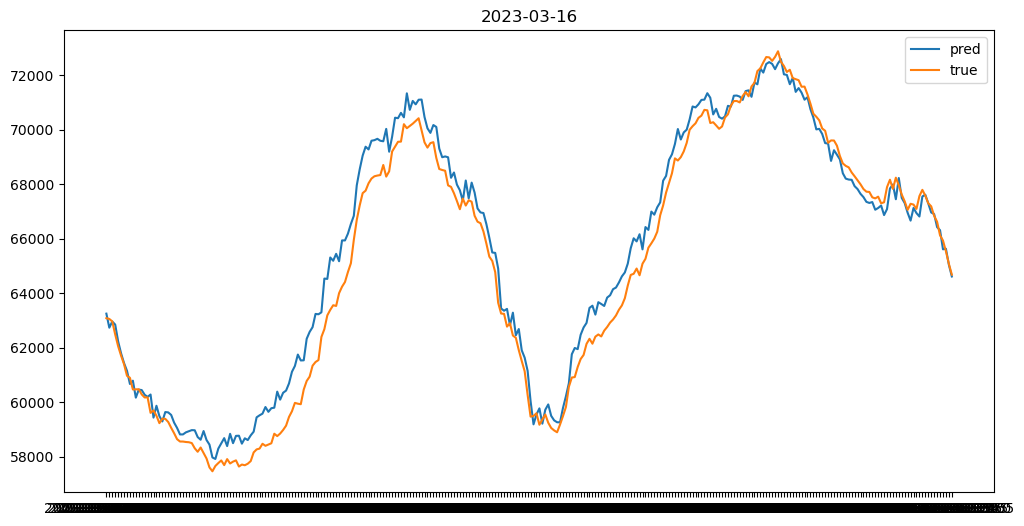

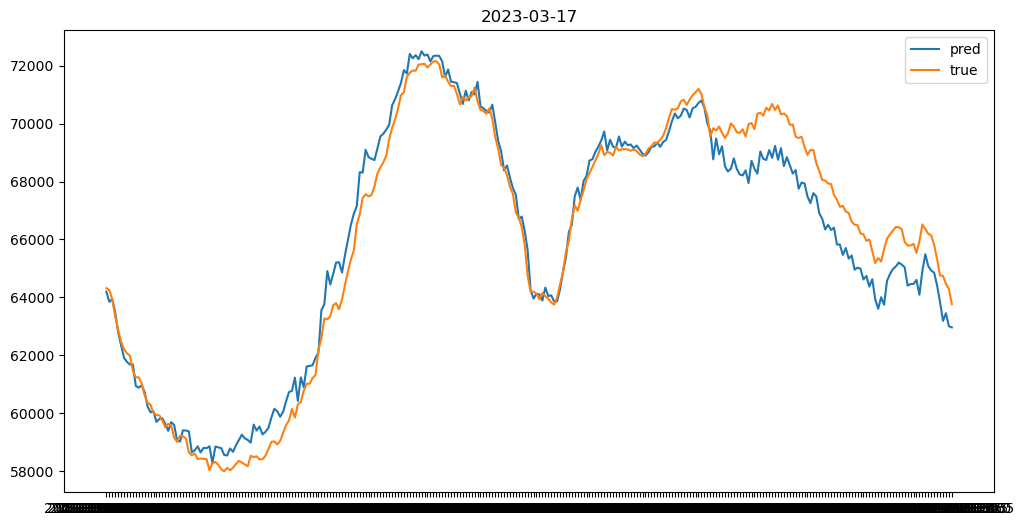

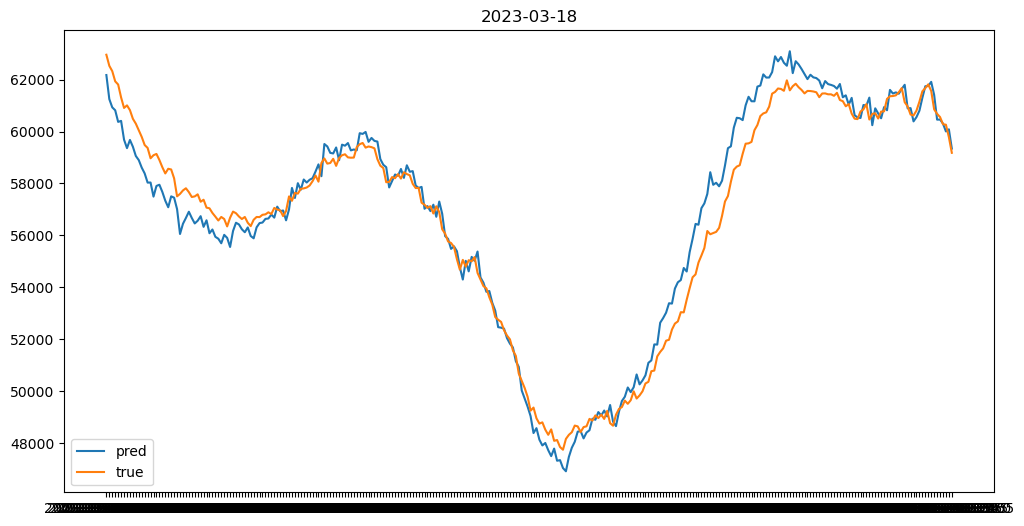

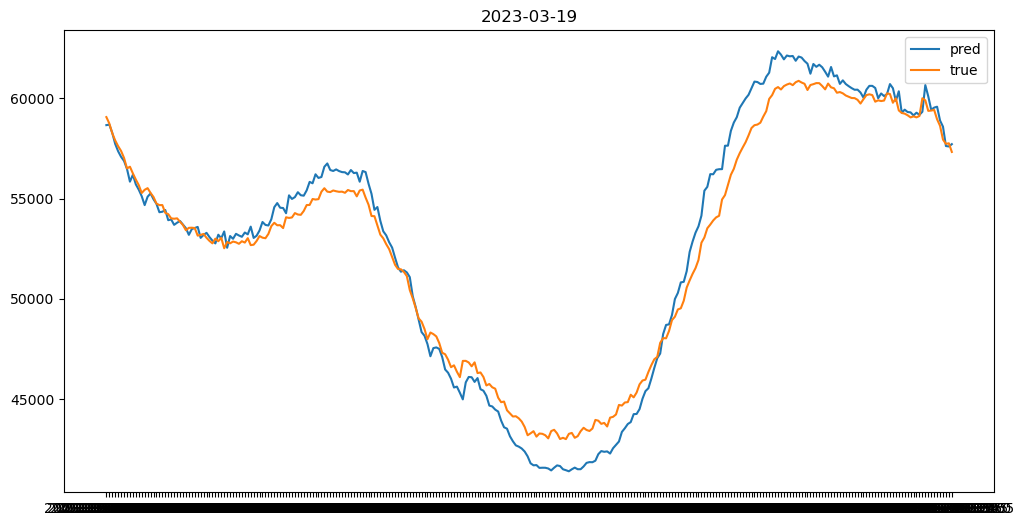

In [104]:
for idx, date in enumerate(['2023-03-13','2023-03-14','2023-03-15','2023-03-16','2023-03-17','2023-03-18','2023-03-19']):
    next_date = (pd.to_datetime(date) + timedelta(days=1)).strftime("%Y-%m-%d")
    plt.figure(figsize=(12,6))
    plt.plot(pred_list[idx][:,0], label='pred')
    plt.plot(target_df.set_index('datetime').loc[date:next_date, 'load'], label='true')
    plt.title(date)
    plt.legend()
    plt.show()

In [76]:
pred_list[0][:,0]

array([58938.023, 58990.14 , 59320.203, 58956.58 , 58465.586, 58559.207,
       58367.426, 57528.098, 57249.75 , 57001.65 , 56819.613, 57555.3  ,
       57438.613, 57312.39 , 56613.254, 56714.652, 56324.12 , 56223.406,
       56536.188, 55813.047, 56190.934, 55868.906, 55686.668, 55584.242,
       55529.1  , 55441.3  , 55491.25 , 55428.887, 55485.76 , 55355.31 ,
       54866.734, 54818.004, 55470.805, 55722.547, 55131.37 , 55468.895,
       54914.44 , 55629.58 , 55533.59 , 55408.73 , 55293.49 , 55416.32 ,
       55350.938, 55714.816, 55251.242, 55624.68 , 55887.68 , 55833.54 ,
       55905.93 , 55910.85 , 56370.51 , 56320.13 , 56628.914, 56431.24 ,
       56359.195, 56348.594, 56632.496, 57110.293, 57214.164, 57627.973,
       58239.676, 58008.97 , 58551.715, 58505.914, 58691.98 , 58994.72 ,
       59313.344, 59696.14 , 60356.473, 59917.805, 60440.766, 60994.31 ,
       61206.457, 61660.72 , 62914.242, 62700.645, 63606.24 , 63889.73 ,
       64193.938, 64123.277, 65247.223, 65087.332, 

In [134]:
model.lstm.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[-0.8856],
                      [-0.3580],
                      [-0.3881],
                      ...,
                      [ 2.4763],
                      [-2.5877],
                      [-0.5698]], device='cuda:0')),
             ('weight_hh_l0',
              tensor([[ 0.0692, -0.0153,  0.2489,  ...,  0.0685,  0.0200, -0.1938],
                      [-0.0282,  0.0480, -0.1078,  ..., -0.1359,  0.0299,  0.1320],
                      [ 0.0099,  0.0730, -0.2831,  ...,  0.2395,  0.0836, -0.1795],
                      ...,
                      [ 0.0171,  0.0812, -0.2656,  ..., -0.2161, -0.2128,  0.1484],
                      [ 0.0227,  0.2473,  0.1939,  ...,  0.2445,  0.0791, -0.1704],
                      [-0.0346, -0.2575, -0.2873,  ..., -0.1821, -0.0679,  0.1978]],
                     device='cuda:0')),
             ('bias_ih_l0',
              tensor([-0.2830,  0.0787, -0.3197,  ...,  0.1310, -0.3462,  0.2336],
            